# LDA with Mean-field VI

**Goal:** Translating the math in slide 25 of lecture 22 to an efficient piece of code.

**Dataset:** State of the Union---same as the previous exercise.

**Dependencies:**

1. `pip install tqdm, sklearn, scipy, numpy, spacy, matplotlib`
2. `python -m spacy download en_core_web_sm`
3. Unzip `Exercise_10_data.zip`, make sure you have the following directory structure: `./data/sotu/`

**Useful external references:**
1. https://arxiv.org/abs/1601.00670 (Also very useful for supplementing what you have seen in the lecture.)
2. http://times.cs.uiuc.edu/course/598f16/notes/lda-survey.pdf

We use the pre-processed texts from the previous exercise.

In [1]:
import numpy as np
import pickle
import tqdm
from scipy.special import digamma
from sklearn.feature_extraction.text import CountVectorizer
import torch
from torch.distributions.dirichlet import Dirichlet
import matplotlib.pyplot as plt

DATA_DIR = './data/'
SOTU_DIR = DATA_DIR + 'sotu/'

# Reduce these values to make things faster, e.g. for debugging
MAX_DOC_LEN = 200
VOCAB_SIZE = 100
# MAX_DOC_LEN = 1000
# VOCAB_SIZE = 600


with open(DATA_DIR+'years.bin', 'rb') as f:
    years = pickle.load(f)

with open(DATA_DIR+'preprocessed.bin', 'rb') as f:
    preprocessed = pickle.load(f)

count_vect = CountVectorizer(max_features=VOCAB_SIZE, stop_words=['000'])
X = count_vect.fit_transform(preprocessed)

X = np.asarray(X.todense())

print(X.shape)


word2idx = count_vect.vocabulary_
idx2word = count_vect.get_feature_names()

(228, 100)


Create the features matrix that we are going to use during inference.

In [2]:
D = len(preprocessed)  # num of docs
V = count_vect.max_features  # vocabulary size

W = np.zeros([D, MAX_DOC_LEN, V], dtype='int8')  # Dataset

for d, doc in enumerate(preprocessed):
    w = []
    
    for word in doc.split(' '):
        try:
            idx = word2idx[word]
            w.append(idx)
        except KeyError:
            pass
        
        if len(w) >= MAX_DOC_LEN:
            break
            
    for i, w_ in enumerate(w):
        W[d, i, w_] = 1

## LDA inference with VI

Recall that in Gibbs sampling (previous exercise), we _sample_ latent variables from the LDA posterior (the LDA model conditioned to documents). In VI, we do a _full distribution approximation_ to the posterior instead. Specifically, we put a simplifying (mean-field) assumption on our model and optimize the reverse KL-divergence between the model and the true posterior.

VI can be seen as casting inference into optimization. While one can use any optimization algorithm to maximize the variational bound (ELBO), here we will implement the simplest algorithm for doing so. The algorithm is termed coordinate-ascent variational-inference (CAVI). It updates each variational distribution in turn using the full-conditional of the corresponding variable. The resulting algorithm is very similar to Gibbs sampling, but to emphasize it again: we do a _full distribution approximation_ to the posterior, and not _sampling_.

**Hint.** The pseudocode for the aforementioned algorithm is in slide 25 of lecture 22.

Let us start with some hyperparameters, similar to the previous exercise sheet.

In [3]:
K = 10  # num of topics

# Dirichlet priors
alpha = 1/K
beta = 1/K

**TASK 1.** Initialize the variational parameters of the three variational distributions:

* $\mathbf{\tilde{\alpha}}_d$, the variational parameter of $q(\mathbf{\pi}_d)$
* $\mathbf{\tilde{\beta}}_k$, the variational parameter of $q(\mathbf{\theta}_k)$
* $\mathbf{\tilde{\gamma}}_{di}$, the variational parameter of $q(\mathbf{c}_{di})$

Vectorize as much as you can---the data structure you choose affects the optimization runtime.

Note again: These variables are parameters to the variational distributions, not for holding samples like in Gibbs sampling.

In [4]:
def mask_invalid(a, valid_mask, k):
    a[~valid_mask] = torch.zeros(k, dtype=a.dtype)

In [5]:
# gamma_tilde := variational parameters of the distributions of the document-word topic assigments
i, j, k = np.where(W)
valid_mask = np.full((D, MAX_DOC_LEN), False)
valid_mask[i, j] = True
# we will need this later :)
wc_m = np.full((D, MAX_DOC_LEN), -1)
wc_m[i,j] = k

gamma_tilde = Dirichlet(torch.tensor([alpha]*K)).rsample((D,MAX_DOC_LEN))
mask_invalid(gamma_tilde, valid_mask, K)

# alpha_tilde := variational parameters of the document-topic distributions
alpha_tilde = torch.full((D,K), alpha)

# beta_tilde := variational parameters of the topic-word distributions
beta_tilde = torch.full((K,V), beta)

Now we will "translate" the pseudocode in the lecture slides into a real (efficient!) code. 

**TASK 2.** Inside the CAVI loop, update $(\mathbf{\tilde{\alpha}}_d), (\mathbf{\tilde{\beta}}_k), (\mathbf{\tilde{\gamma}}_{di})$ in turn. Vectorize the update as much as you can!

Note that, the computation of the ELBO is not necessary and you can skip this step. 

In [6]:
N_ITER = 100

v_m = [np.where(wc_m == v) for v in range(V)]

for it in tqdm.trange(N_ITER):
    # Update alpha_tilde
    # ------------------
    alpha_tilde = gamma_tilde.sum(axis=1)

    # Update beta_tilde
    # -----------------
    beta_tilde = torch.stack([gamma_tilde[vm].sum(axis=0) for vm in v_m]).T
        
    # Update gamma_tilde
    # ------------------
    digamma_alpha = digamma(alpha_tilde)
    digamma_beta = digamma(beta_tilde)
    digamma_sum_beta = digamma(beta_tilde.sum(axis=-1))
    bigsum = torch.stack([digamma_beta[:, wc_m[d, md]]  for d in range(D) for md in range(MAX_DOC_LEN)]).reshape(D, MAX_DOC_LEN, K)
    bigsum += digamma_alpha.unsqueeze(axis=1)
    bigsum -= digamma_sum_beta
    gamma_tilde = torch.exp(bigsum)
    
    gamma_tilde /= gamma_tilde.sum(axis=-1, keepdims=True)
    mask_invalid(gamma_tilde, valid_mask, K)
    

100%|██████████| 100/100 [00:21<00:00,  4.74it/s]


## Testing

After we have successfully found all the variational parameters (and thus the variational distributions), we are ready to evaluate the inferred latent variables.

**TASK 3.** Print the _expected_ top-$n$ words for each topic, weigthed by its importance! To do this, recall, for each topic $k$, which variational distribution approximates the $k$-th topic-word distribution. See the previous exercise sheet (Sheet 10) for the explanation of "importance weigthing".

**Hint.** Expected result:

```
Topic-1
company dollar financial century income wage cost export

Topic-2
commissioner states vessel naval convention minister island treaty

Topic-3
china cent currency bond expenditure surplus bank gold

Topic-4
enemy fight war defense production military strength army

...
```

In [7]:
n = 8

top_vals, inds = torch.topk(beta_tilde, n, axis=-1)
np_idx2word = np.array(idx2word)
print(np_idx2word[inds])
# print(inds)

[['treaty' 'country' 'citizen' 'subject' 'nation' 'act' 'commerce'
  'power']
 ['public' 'country' 'expenditure' 'year' 'increase' 'present'
  'necessary' 'work']
 ['interest' 'year' 'american' 'foreign' 'relation' 'question'
  'government' 'trade']
 ['national' 'trade' 'service' 'foreign' 'present' 'world' 'way' 'policy']
 ['law' 'power' 'right' 'act' 'shall' 'duty' 'state' 'public']
 ['war' 'force' 'million' 'year' 'great' 'peace' 'military' 'time']
 ['people' 'continue' 'government' 'power' 'state' 'large' 'end'
  'present']
 ['business' 'man' 'work' 'country' 'great' 'people' 'good' 'need']
 ['year' 'new' 'people' 'program' 'work' 'help' 'time' 'world']
 ['nation' 'world' 'peace' 'war' 'people' 'great' 'free' 'man']]


Finally, as before, let us visualize the change of topics over time.

**TASK 4.** Plot the _expected_ document-topic proportion sequentially, ordered by year. See Fig. 5 in https://arxiv.org/abs/1110.4713 for an example!

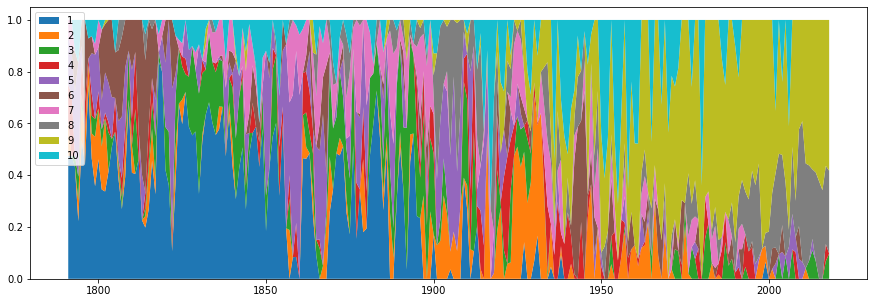

In [8]:
yrs = np.array(years)
yrs_sort_index = yrs.argsort()
doc_props = np.array(alpha_tilde[yrs_sort_index]/alpha_tilde[yrs_sort_index].sum(axis=1 , keepdims=True))

plt.rcParams["figure.figsize"]=15,5
plt.stackplot(yrs[yrs_sort_index], doc_props.T, labels=["1","2","3","4","5","6","7","8","9","10"])
plt.legend(loc='upper left')
plt.show()